# CNN-based Lane line detection

I used the following reference with a little updating the code:
__[GitHub Reference page](https://github.com/mvirgo/MLND-Capstone)__

### Model details:

CNN is used to calculate the polynomial coefficients of the lane lines, and then draw the lane
area based off of those lines. This approach, similar to a regression-type problem, made sense
to use mean-squared error to minimize loss, meaning the difference between the actual
coefficients and the model’s prediction (MSE uses the mean of all the squared differences to
calculate loss). MSE is also utilized for the fully convolutional neural
network (i.e. one that lacks any fully connected layers) to generate the green lane to be drawn
onto the original image. Using MSE here meant minimizing the loss between the predicted pixel
values of the output lane image and what the lane image label was.

importing required modules and functions:

In [2]:
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

Defining required function:

<code> create_model() </code> recieves input data dimensions and the pooling layer size. It then determines each layer parameters.

In [2]:
def create_model(input_shape, pool_size):
    # Create the actual neural network here
    model = Sequential()
    # Normalizes incoming inputs. First layer needs the input shape to work
    model.add(BatchNormalization(input_shape=input_shape))

    # Below layers were re-named for easier reading of model summary; this not necessary
    # Conv Layer 1
    model.add(Conv2D(8, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv1'))

    # Conv Layer 2
    model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv2'))

    # Pooling 1
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 3
    model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv3'))
    model.add(Dropout(0.2))

    # Conv Layer 4
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv4'))
    model.add(Dropout(0.2))

    # Conv Layer 5
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv5'))
    model.add(Dropout(0.2))

    # Pooling 2
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 6
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv6'))
    model.add(Dropout(0.2))

    # Conv Layer 7
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Conv7'))
    model.add(Dropout(0.2))

    # Pooling 3
    model.add(MaxPooling2D(pool_size=pool_size))

    # Upsample 1
    model.add(UpSampling2D(size=pool_size))

    # Deconv 1
    model.add(Conv2DTranspose(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv1'))
    model.add(Dropout(0.2))

    # Deconv 2
    model.add(Conv2DTranspose(64, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv2'))
    model.add(Dropout(0.2))

    # Upsample 2
    model.add(UpSampling2D(size=pool_size))

    # Deconv 3
    model.add(Conv2DTranspose(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv3'))
    model.add(Dropout(0.2))

    # Deconv 4
    model.add(Conv2DTranspose(32, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv4'))
    model.add(Dropout(0.2))

    # Deconv 5
    model.add(Conv2DTranspose(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv5'))
    model.add(Dropout(0.2))

    # Upsample 3
    model.add(UpSampling2D(size=pool_size))

    # Deconv 6
    model.add(Conv2DTranspose(16, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Deconv6'))

    # Final layer - only including one channel so 1 filter
    model.add(Conv2DTranspose(1, (3, 3), padding='same', strides=(1,1), activation = 'relu', name = 'Final'))

    return model

Training samples:

The videos were filmed in 720p in horizontal/landscape mode, with 720 pixels on
the y-axis and 1280 pixels on the x-axis, at 30 fps. In order to cut down on training time, the
training images were scaled down to 80 by 160 pixels (a slightly different aspect ratio than the beginning, primarily as it made it easier for appropriate calculations when going deeper in the
final CNN architecture). In order to calculate the original labels, which were six coefficients (three
for each lane line, with each of the three being a coefficient for a polynomial-fit lane line), we also
have to do a few basic computer vision techniques first. first, perform image calibration with
OpenCV to correct for camera’s inherent distortion, and then use perspective transformation
to put the road lines on a flat plane.


Here we load the training samples from __[here](https://www.dropbox.com/s/rrh8lrdclzlnxzv/full_CNN_train.p?dl=0)__ (downloaded as <code>full_CNN_train.p</code>)

and the associated labels from __[here](https://www.dropbox.com/s/ak850zqqfy6ily0/full_CNN_labels.p?dl=0)__ (downloaded as <code>full_CNN_labels.p</code>)

In [3]:
train_images_origin = pickle.load(open("full_CNN_train.p", "rb" ))

labels_origin = pickle.load(open("full_CNN_labels.p", "rb" ))

Here we reshape the image data into numpy ndarray as our neural network requires:

In [4]:
train_images = np.array(train_images_origin)
labels = np.array(labels_origin)

As the images are colored, we normalize the labels to be within (0,1) interval:

In [7]:
labels = labels / 255

Finally we shuffle the training set data and split them into train and validation sets:

In [8]:
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

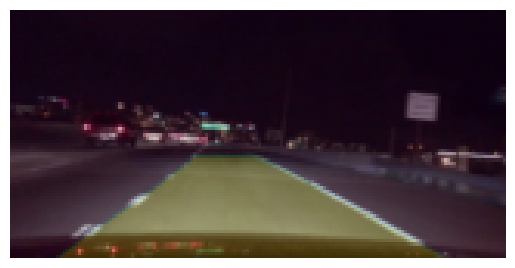

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.axis('off') 

plt.imshow(train_images_origin[0], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.imshow(labels_origin[0],alpha=0.2)  # Use 'gray' colormap for grayscale images

# Show the plot
plt.show()

In [6]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def display_pred(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'predicted Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

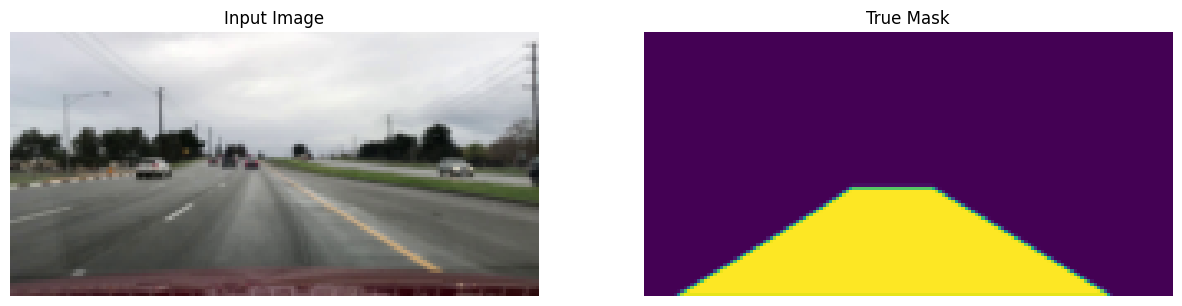

In [33]:
display([X_train[1], y_train[1]])

Here we determine our model parameters. The parameters <code>batch_size</code>, <code>epochs</code> and <code>pool_size</code> can be iterated in a suitable interval to optimize the model

In [10]:
# Determine parameters:
batch_size = 128
epochs = 10  
pool_size = (2, 2)
input_shape = X_train.shape[1:]

# Create the neural network
model = create_model(input_shape, pool_size)
model.compile(optimizer='Adam', loss='mean_squared_error',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 80, 160, 3)       12        
 ormalization)                                                   
                                                                 
 Conv1 (Conv2D)              (None, 80, 160, 8)        224       
                                                                 
 Conv2 (Conv2D)              (None, 80, 160, 16)       1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 80, 16)       0         
 )                                                               
                                                                 
 Conv3 (Conv2D)              (None, 40, 80, 16)        2320      
                                                                 
 dropout (Dropout)           (None, 40, 80, 16)        0

In [11]:
history = model.fit(X_train, y_train, batch_size=batch_size, steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
89/89 [==============================] - 446s 5s/step - loss: 0.0823 - accuracy: 0.8714 - val_loss: 0.0432 - val_accuracy: 0.9124
Epoch 2/10
89/89 [==============================] - 456s 5s/step - loss: 0.0218 - accuracy: 0.9455 - val_loss: 0.0171 - val_accuracy: 0.9466
Epoch 3/10
89/89 [==============================] - 446s 5s/step - loss: 0.0141 - accuracy: 0.9531 - val_loss: 0.0127 - val_accuracy: 0.9525
Epoch 4/10
89/89 [==============================] - 430s 5s/step - loss: 0.0116 - accuracy: 0.9560 - val_loss: 0.0102 - val_accuracy: 0.9566
Epoch 5/10
89/89 [==============================] - 429s 5s/step - loss: 0.0101 - accuracy: 0.9576 - val_loss: 0.0093 - val_accuracy: 0.9576
Epoch 6/10
89/89 [==============================] - 442s 5s/step - loss: 0.0091 - accuracy: 0.9583 - val_loss: 0.0085 - val_accuracy: 0.9584
Epoch 7/10
89/89 [==============================] - 432s 5s/step - loss: 0.0083 - accuracy: 0.9589 - val_loss: 0.0075 - val_accuracy: 0.9586
Epoch 8/10
89

In [27]:
y_pred[0].shape

(80, 160, 1)

In [35]:
y_pred = model.predict(X_train[1:2])

1/1 [==============================] - 0s 36ms/step


In [ ]:
X_train[1:2].shape

(1, 80, 160, 3)

1/1 [==============================] - 0s 29ms/step


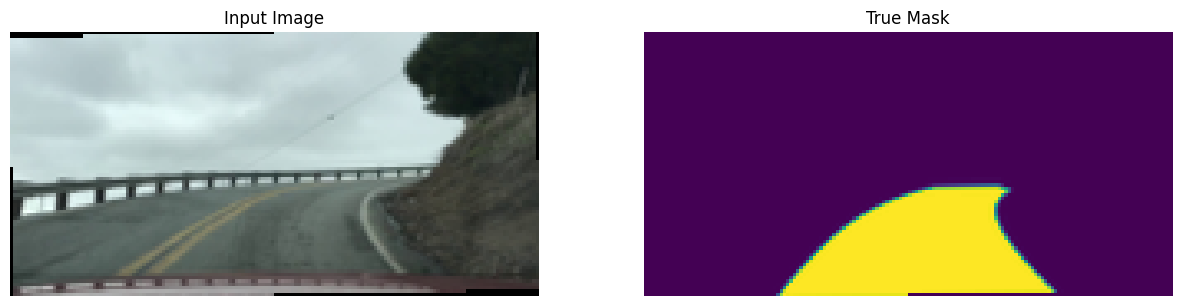

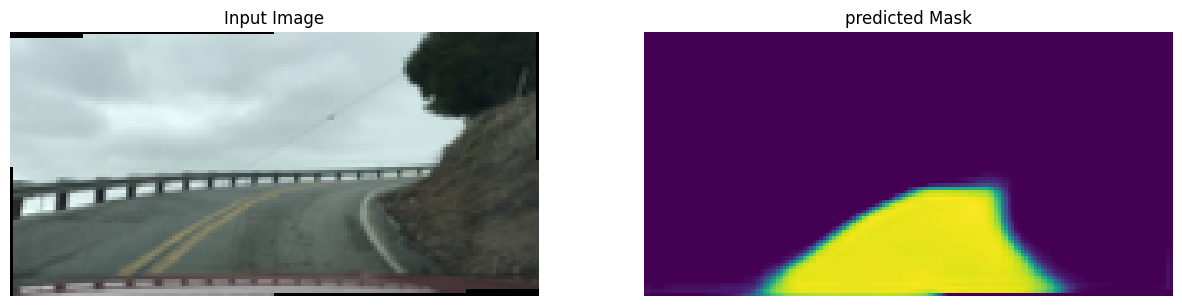

In [42]:
y_pred = model.predict(X_val[1:2])

display([X_val[1], y_val[1]])
display_pred([X_val[1], y_pred[0]])

In [12]:
model.save('full_CNN_model1.h5')

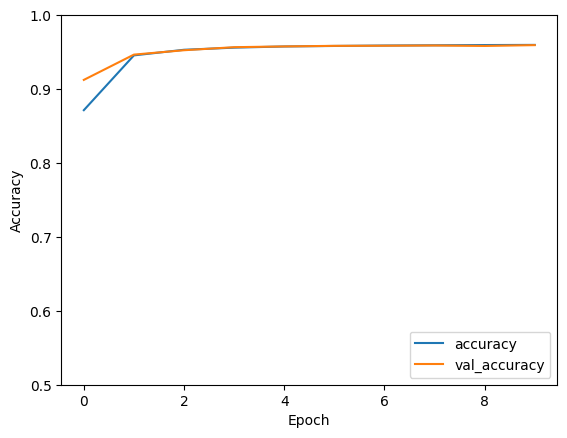

In [43]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')